# linear regression

In [32]:
import pandas as pd
import seaborn as sns
sns.set(context="notebook",style="whitegrid",palette="dark")
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [33]:
df = pd.read_csv('ex1data1.txt',names=['population','profit'])#读取数据并赋予列名

In [34]:
df.head()#查看前五行

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   population  97 non-null     float64
 1   profit      97 non-null     float64
dtypes: float64(2)
memory usage: 1.6 KB


## 查看原始数据

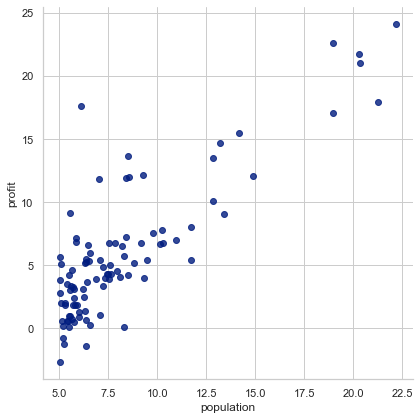

In [36]:
sns.lmplot(x='population',y='profit', data=df, height=6, fit_reg=False)
plt.show()

In [41]:
def get_X(df):#读取特征
    ones = pd.DataFrame({'ones':np.ones(len(df))})#ones是m行1列的dataframe
    data = pd.concat([ones,df],axis=1)#合并数据，根据列合并
    #return data.iloc[:, :-1].as_matrix()#返回ndarray,不是矩阵
    return data.iloc[:, :-1].values#返回ndarray,不是矩阵

def get_y(df):#读取标签
    return np.array(df.iloc[:,-1])

def normalize_feature(df):
    return df.apply(lambda column:(column - column.mean()) / column.std())#特征缩放

多变量的假设h表示为：

$h_\theta(x)=\theta_0+\theta{1}x_1+\theta_{2}x_2+\cdots+\theta_{n}x_n$

这个公式中有n+1个参数和n个变量，为了使得公式能够简化一些，引入$x_0=1$,则公式转换为：

此时模型中的参数是一个n+1维的向量，任何一个训练实例也都是n+1维的向量，特征矩阵X的维度是m*(n+1)。因此公式可以简化为：$h_\theta(x)=\theta^{T}X$,其中上标T代表矩阵转置

In [38]:
def linear_regression(X_data, y_data, alpha, epoch, optimizer=tf.compat.v1.train.GradientDescentOptimizer):# 这个函数是旧金山的一个大神Lucas Shen写的
      # placeholder for graph input
    X = tf.placeholder(tf.float32, shape=X_data.shape)
    y = tf.placeholder(tf.float32, shape=y_data.shape)

    # construct the graph
    with tf.variable_scope('linear-regression'):
        W = tf.get_variable("weights",
                            (X_data.shape[1], 1),
                            initializer=tf.constant_initializer())  # n*1

        y_pred = tf.matmul(X, W)  # m*n @ n*1 -> m*1

        loss = 1 / (2 * len(X_data)) * tf.matmul((y_pred - y), (y_pred - y), transpose_a=True)  # (m*1).T @ m*1 = 1*1

    opt = optimizer(learning_rate=alpha)
    opt_operation = opt.minimize(loss)

    # run the session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        loss_data = []

        for i in range(epoch):
            _, loss_val, W_val = sess.run([opt_operation, loss, W], feed_dict={X: X_data, y: y_data})
            loss_data.append(loss_val[0, 0])  # because every loss_val is 1*1 ndarray

            if len(loss_data) > 1 and np.abs(loss_data[-1] - loss_data[-2]) < 10 ** -9:  # early break when it's converged
                # print('Converged at epoch {}'.format(i))
                break

    # clear the graph
    tf.reset_default_graph()
    return {'loss': loss_data, 'parameters': W_val}  # just want to return in row vector format

In [39]:
data = pd.read_csv('ex1data1.txt',names=['population','profit'])#读取数据，并赋予列名
data.head()#查看数据前5行

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


## 计算代价函数

$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}$$
其中：\\[{{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}\\] 

In [43]:
X = get_X(data)
print(X.shape,type(X))

y = get_y(data)
print(y.shape,type(y))
#查看数据维度

(97, 2) <class 'numpy.ndarray'>
(97,) <class 'numpy.ndarray'>


In [44]:
theta = np.zeros(X.shape[1])#X.shape[1]=2，代表特征数n

In [45]:
def lr_cost(theta, X, y):
#     """
#     X: R(m*n), m 样本数, n 特征数
#     y: R(m)
#     theta : R(n), 线性回归的参数
#     """
    m = X.shape[0]#m为样本数

    inner = X @ theta - y  # R(m*1)，X @ theta等价于X.dot(theta)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [46]:
lr_cost(theta,X,y)#返回theta的值

32.072733877455676

# batch gradient decent（批量梯度下降）
$${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$$

In [47]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)，X @ theta等价于X.dot(theta)

    return inner / m

In [48]:
def batch_gradient_decent(theta, X, y, epoch, alpha=0.01):
#   拟合线性回归，返回参数和代价
#     epoch: 批处理的轮数
#     """
    cost_data = [lr_cost(theta, X, y)]
    _theta = theta.copy()  # 拷贝一份，不和原来的theta混淆

    for _ in range(epoch):
        _theta = _theta - alpha * gradient(_theta, X, y)
        cost_data.append(lr_cost(_theta, X, y))

    return _theta, cost_data
#批量梯度下降函数

In [49]:
epoch = 500
final_theta, cost_data = batch_gradient_decent(theta, X, y ,epoch)

In [50]:
final_theta

array([-2.28286727,  1.03099898])

In [51]:
cost_data

[32.072733877455676,
 6.737190464870009,
 5.931593568604956,
 5.901154707081388,
 5.895228586444221,
 5.890094943117332,
 5.885004158443646,
 5.8799324804914175,
 5.874879094762575,
 5.869843911806386,
 5.864826865312929,
 5.859827889932181,
 5.85484692057229,
 5.849883892376587,
 5.844938740722034,
 5.840011401218361,
 5.835101809707226,
 5.830209902261388,
 5.825335615183862,
 5.820478885007099,
 5.815639648492152,
 5.810817842627869,
 5.806013404630044,
 5.801226271940628,
 5.796456382226899,
 5.7917036733806535,
 5.786968083517396,
 5.782249550975539,
 5.777548014315596,
 5.772863412319381,
 5.768195683989212,
 5.76354476854712,
 5.758910605434047,
 5.7542931343090755,
 5.749692295048629,
 5.745108027745684,
 5.740540272709014,
 5.735988970462381,
 5.731454061743792,
 5.726935487504702,
 5.722433188909257,
 5.717947107333529,
 5.713477184364749,
 5.709023361800549,
 5.704585581648199,
 5.700163786123856,
 5.695757917651815,
 5.691367918863752,
 5.686993732597982,
 5.682635301898707

In [52]:
#计算最终的代价
lr_cost(final_theta, X, y)

4.713809531116866

# visualize cost data (代价数据可视化)

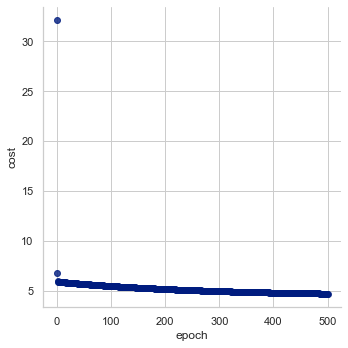

In [57]:
c = {'epoch':list(range(epoch+1)),'cost':cost_data}
cost_df = pd.DataFrame(c)
ax = sns.lmplot(x='epoch', y='cost', data=cost_df, fit_reg=False)
plt.show()

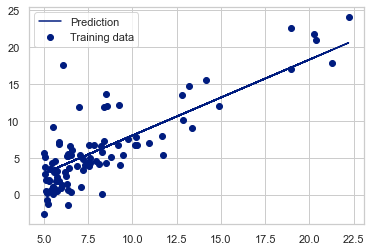

In [58]:
b = final_theta[0] # intercept，Y轴上的截距
m = final_theta[1] # slope，斜率

plt.scatter(data.population, data.profit, label="Training data")
plt.plot(data.population, data.population*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()